Model: Gradient Boosting Regressor treniran. R2 na testni množici: 0.674
--- Zaganjam simulacije za VSE značilke ---

=== 6. Testiranje globalnih sprememb (Simulacije) ===
                              Scenario  Avg Tenure (Pred)  Avg Tenure (Po)  Razlika Sprememba (%)
             Vsi na: Contract_Two year             31.915           52.323   20.408        63.94%
             Vsi na: Contract_One year             31.915           39.227    7.312        22.91%
        Znižanje MonthlyCharges (-20%)             31.915           30.006   -1.909        -5.98%
         Aktivacija: MultipleLines_Yes             31.915           34.737    2.822         8.84%
               Aktivacija: Partner_Yes             31.915           34.927    3.011         9.44%
          Aktivacija: OnlineBackup_Yes             31.915           35.177    3.261        10.22%
    Vsi na: PaymentMethod_Mailed check             31.915           26.799   -5.116       -16.03%
                 Aktivacija: Churn_Yes      

C:\Users\Matic\AppData\Local\Temp\ipykernel_22636\972831811.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sigma_imps, y=scenarios, palette="coolwarm", orient='h')


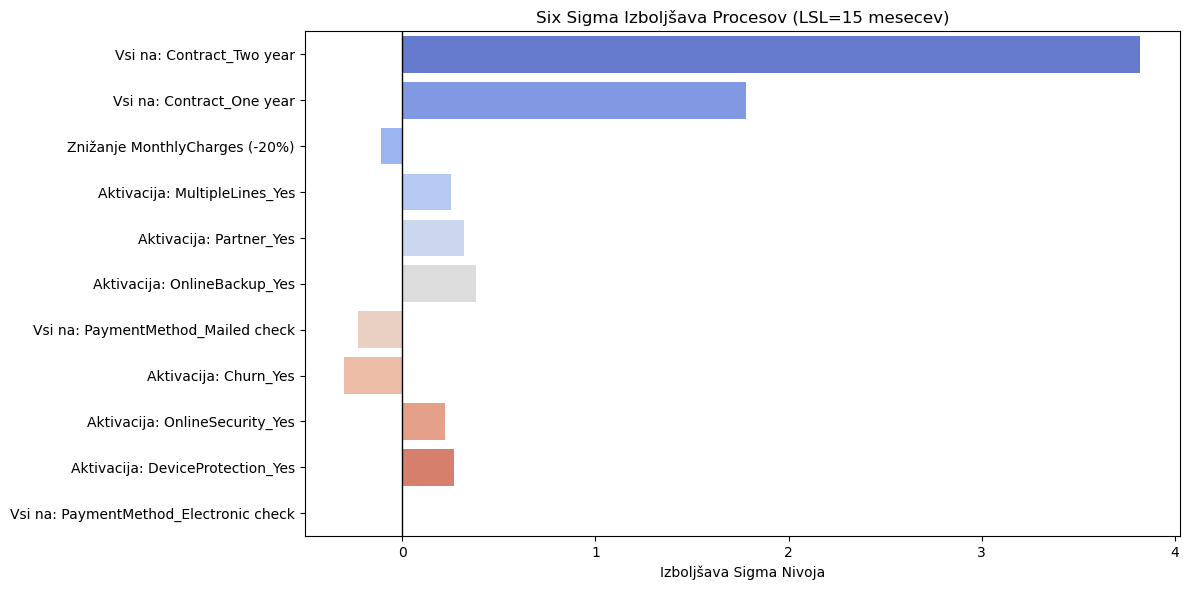

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# --- 1. PRIPRAVA PODATKOV (Kopirano in prilagojeno iz regresijskoUcenje.py) ---
try:
    df = pd.read_csv("Telco-Customer-Churn-Cleaned.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv("../Telco-Customer-Churn-Cleaned.csv")
    except FileNotFoundError:
        print("Napaka: Datoteke s podatki ni mogoče najti.")
        exit()

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges', 'tenure'])

df_model = df.copy()
drop_cols = ["customerID", "TotalCharges"] 
df_model = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns])

y = df_model["tenure"]
X = df_model.drop(columns=["tenure"])

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Izbor značilk (mora biti enak kot pri učenju modela)
selected_features = [
    "Contract_Two year", "Contract_One year", "MonthlyCharges", 
    "MultipleLines_Yes", "Partner_Yes", "OnlineBackup_Yes", 
    "PaymentMethod_Mailed check", "Churn_Yes", "OnlineSecurity_Yes", 
    "DeviceProtection_Yes", "PaymentMethod_Electronic check"
]

# Preverimo, če katere značilke manjkajo in jih dodamo z 0 (redkost, a previdnost ne škodi)
for feat in selected_features:
    if feat not in X_encoded.columns:
        X_encoded[feat] = 0

X_final = X_encoded[selected_features]
y_final = df["tenure"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

# --- 2. UČENJE MODELA ---
# Uporabimo Gradient Boosting kot "izbran model" za simulacijo
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

print(f"Model: Gradient Boosting Regressor treniran. R2 na testni množici: {model.score(X_test, y_test):.3f}")

# --- 3. DEFINICIJA SIMULACIJ ---

LSL = 15 # Lower Specification Limit (Meseci) - Cilj je zadržati kupca vsaj 15 mesecev

# Funkcija za izračun in izpis rezultatov
def evaluate_simulation(model, X_original, X_simulated, scenario_name, lsl=LSL):
    pred_original = model.predict(X_original)
    pred_simulated = model.predict(X_simulated)
    
    avg_original = np.mean(pred_original)
    avg_simulated = np.mean(pred_simulated)
    diff = avg_simulated - avg_original
    pct_change = (diff / avg_original) * 100
    
    # Six Sigma Calculations
    def calc_sigma(data, limit):
        defects = np.sum(data < limit)
        n = len(data)
        if n == 0: return 0, 0
        dpmo = (defects / n) * 1_000_000
        yield_rate = 1 - (defects / n)
        
        if yield_rate >= 0.999997: # Cap at ~6 sigma
             sigma = 6.0
        elif yield_rate <= 0.000001: 
             sigma = 0.0
        else:
             sigma = stats.norm.ppf(yield_rate) + 1.5
        return dpmo, sigma

    dpmo_prej, sigma_prej = calc_sigma(pred_original, lsl)
    dpmo_potem, sigma_potem = calc_sigma(pred_simulated, lsl)
    imp_sigma = sigma_potem - sigma_prej
    
    return {
        "Model": "Gradient Boosting",
        "Scenario": scenario_name,
        "Avg Tenure (Pred)": round(avg_original, 3),
        "Avg Tenure (Po)": round(avg_simulated, 3),
        "Razlika": round(diff, 3),
        "Sprememba (%)": f"{round(pct_change, 2)}%",
        "DPMO PREJ": int(dpmo_prej),
        "Sigma PREJ": round(sigma_prej, 2),
        "DPMO POTEM": int(dpmo_potem),
        "Sigma POTEM": round(sigma_potem, 2),
        "Izboljšava Sigma": round(imp_sigma, 2)
    }

results = []

print("--- Zaganjam simulacije za VSE značilke ---")

for feature in selected_features:
    X_sim = X_test.copy()
    
    # 1. Numerične značilke (MonthlyCharges)
    if feature == "MonthlyCharges":
        X_sim[feature] = X_sim[feature] * 0.8
        scenario_name = "Znižanje MonthlyCharges (-20%)"
    
    # 2. Pogodbene značilke (Contract) - medsebojno izključevanje
    elif "Contract" in feature:
        X_sim[feature] = 1
        # Nastavimo ostale Contract značilke na 0
        for col in X_test.columns:
            if "Contract" in col and col != feature:
                X_sim[col] = 0
        scenario_name = f"Vsi na: {feature}"
        
    # 3. Plačilne metode (PaymentMethod) - medsebojno izključevanje
    elif "PaymentMethod" in feature:
        X_sim[feature] = 1
        for col in X_test.columns:
            if "PaymentMethod" in col and col != feature:
                X_sim[col] = 0
        scenario_name = f"Vsi na: {feature}"
        
    # 4. Binarne značilke (vse ostalo, npr. _Yes)
    else:
        # Če je znakilnost že binarna (0/1), jo nastavimo na 1 (aktivacija)
        X_sim[feature] = 1
        scenario_name = f"Aktivacija: {feature}"
        
    results.append(evaluate_simulation(model, X_test, X_sim, scenario_name))


# --- 4. PRIKAZ REZULTATOV ---
results_df = pd.DataFrame(results)

print("\n=== 6. Testiranje globalnih sprememb (Simulacije) ===")
cols_basic = ["Scenario", "Avg Tenure (Pred)", "Avg Tenure (Po)", "Razlika", "Sprememba (%)"]
print(results_df[cols_basic].to_string(index=False))

print(f"\n=== Six Sigma Analiza (Tolerance: Tenure >= {LSL} mesecev) ===")
cols_sigma = ["Scenario", "DPMO PREJ", "Sigma PREJ", "DPMO POTEM", "Sigma POTEM", "Izboljšava Sigma"]
print(results_df[cols_sigma].to_string(index=False))

# Interpretacija
print("\n--- Interpretacija učinkov ---")
for res in results:
    s = res['Scenario']
    d = res['Razlika']
    imp = res['Izboljšava Sigma']
    sig_prej = res['Sigma PREJ']
    sig_potem = res['Sigma POTEM']
    
    if d > 0:
        desc = f"Povečanje sigma nivoja iz {sig_prej} na {sig_potem} (+{imp})."
        stat_sig = "POMEMBNA" if imp > 0.1 else "MANJŠA"
        print(f"- {s}: {desc} Izboljšava je {stat_sig}." + (" Upravičuje implementacijo." if imp > 0.3 else ""))
    else:
        print(f"- {s}: Ni izboljšanja sigma nivoja ({imp}). Verjetno neupravičeno.")

# Vizualizacija
scenarios = [r['Scenario'] for r in results]
sigma_imps = [r['Izboljšava Sigma'] for r in results]

plt.figure(figsize=(12, 6))
sns.barplot(x=sigma_imps, y=scenarios, palette="coolwarm", orient='h')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Izboljšava Sigma Nivoja")
plt.title(f"Six Sigma Izboljšava Procesov (LSL={LSL} mesecev)")
plt.tight_layout()
plt.show()

## Rezultati simulacij

| Model | Scenario | Avg Tenure (Pred) | Avg Tenure (Po) | Razlika | Sprememba (%) |
|-------|----------|-------------------|-----------------|---------|---------------|
| Gradient Boosting | Vsi na: Contract_Two year | 31.915 | 52.323 | 20.408 | 63.94% |
| Gradient Boosting | Vsi na: Contract_One year | 31.915 | 39.227 | 7.312 | 22.91% |
| Gradient Boosting | Znižanje MonthlyCharges (-20%) | 31.915 | 30.006 | -1.909 | -5.98% |
| Gradient Boosting | Aktivacija: MultipleLines_Yes | 31.915 | 34.737 | 2.822 | 8.84% |
| Gradient Boosting | Aktivacija: Partner_Yes | 31.915 | 34.927 | 3.011 | 9.44% |
| Gradient Boosting | Aktivacija: OnlineBackup_Yes | 31.915 | 35.177 | 3.261 | 10.22% |
| Gradient Boosting | Vsi na: PaymentMethod_Mailed check | 31.915 | 26.799 | -5.116 | -16.03% |
| Gradient Boosting | Aktivacija: Churn_Yes | 31.915 | 28.585 | -3.331 | -10.44% |
| Gradient Boosting | Aktivacija: OnlineSecurity_Yes | 31.915 | 33.147 | 1.231 | 3.86% |
| Gradient Boosting | Aktivacija: DeviceProtection_Yes | 31.915 | 34.013 | 2.097 | 6.57% |
| Gradient Boosting | Vsi na: PaymentMethod_Electronic check | 31.915 | 32.016 | 0.101 | 0.32% |

## Interpretacija učinkov

- **Vsi na: Contract_Two year**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 20.41 mesecev (63.94%).
- **Vsi na: Contract_One year**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 7.31 mesecev (22.91%).
- **Znižanje MonthlyCharges (-20%)**: Učinek je negativen/ničen. Pričakovana doba (Tenure) se skrajša ali ne spremeni za 1.91 mesecev (-5.98%).
- **Aktivacija: MultipleLines_Yes**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 2.82 mesecev (8.84%).
- **Aktivacija: Partner_Yes**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 3.01 mesecev (9.44%).
- **Aktivacija: OnlineBackup_Yes**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 3.26 mesecev (10.22%).
- **Vsi na: PaymentMethod_Mailed check**: Učinek je negativen/ničen. Pričakovana doba (Tenure) se skrajša ali ne spremeni za 5.12 mesecev (-16.03%).
- **Aktivacija: Churn_Yes**: Učinek je negativen/ničen. Pričakovana doba (Tenure) se skrajša ali ne spremeni za 3.33 mesecev (-10.44%).
- **Aktivacija: OnlineSecurity_Yes**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 1.23 mesecev (3.86%).
- **Aktivacija: DeviceProtection_Yes**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 2.10 mesecev (6.57%).
- **Vsi na: PaymentMethod_Electronic check**: Učinek je pozitiven. Pričakovana doba (Tenure) se podaljša za 0.10 mesecev (0.32%).